In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
from scipy.stats import expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime, timedelta

# EDA

In [2]:
zone1 = pd.read_csv(
    "data/out_1.csv",
    usecols=["Datum", "Uhrzeit", "Masse [kg]", "Geschwindigkeit [m/s]"],
)
zone2 = pd.read_csv("data/out_2.csv", usecols=["Date", "Uhrzeit", "m [kg]", "v [m/s]"])
zone1.columns = ["date", "time", "kg", "m/s"]
zone2.columns = ["date", "time", "kg", "m/s"]

In [3]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235   99.250000  37.790625
std     695.884703   1.989189  104.072555   5.395778
min      12.000000   3.600000    0.000000  24.900000
25%     214.750000   7.300000   36.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

In [4]:
zone1.head()

,date,time,kg,m/s
0,2019-01-01,09:00,194.0,8.4
1,2019-01-01,21:00,224.0,8.8
2,2019-01-02,14:00,3104.0,9.2
3,2019-01-04,15:00,228.0,8.0
4,2019-01-05,23:00,755.0,7.0


### NAs

In [5]:
# Check for NaN values
print(zone1.isna().sum())

# Check for zeros
print(zone1.eq(0).sum())

date    11
time    11
kg      11
m/s     11
dtype: int64
date    0
time    0
kg      0
m/s     0
dtype: int64


In [6]:
# Drop lines with only NA values
zone1 = zone1.dropna(how="all")

In [7]:
zone2.head()

,date,time,kg,m/s
0,2019-01-01,09:00,38.0,45.4
1,2019-01-03,06:00,187.0,41.6
2,2019-01-04,10:00,36.0,44.6
3,2019-01-07,14:00,6.0,41.2
4,2019-01-11,06:00,65.0,39.6


In [8]:
# Check for NaN values
print(zone2.isna().sum())

# Check for zeros
print(zone2.eq(0).sum())

date    3
time    3
kg      3
m/s     3
dtype: int64
date    0
time    0
kg      1
m/s     0
dtype: int64


In [9]:
# Drop lines with only NA values
zone2 = zone2.dropna(how="all")

In [10]:
# Set the value to the median in the row where 'kg' equals 0.0
# This rock is not removed from the data, because we do not have a lot of data and this might just have been an error in the measurement
zone2.loc[zone2["kg"] == 0.0, "kg"] = zone2["kg"].median()
# TODO: try to drop the row and check if there is a difference? or go up to 1? -> how do the parameters change (don't run simulation)?

In [11]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235  101.062500  37.790625
std     695.884703   1.989189  102.785382   5.395778
min      12.000000   3.600000    3.000000  24.900000
25%     214.750000   7.300000   37.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

# Visualization

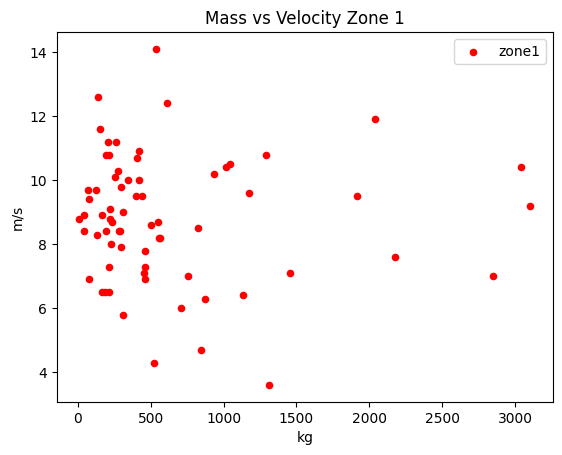

In [12]:
zone1.plot(
    x="kg",
    y="m/s",
    kind="scatter",
    c="red",
    label="zone1",
    title="Mass vs Velocity Zone 1",
)
plt.show()

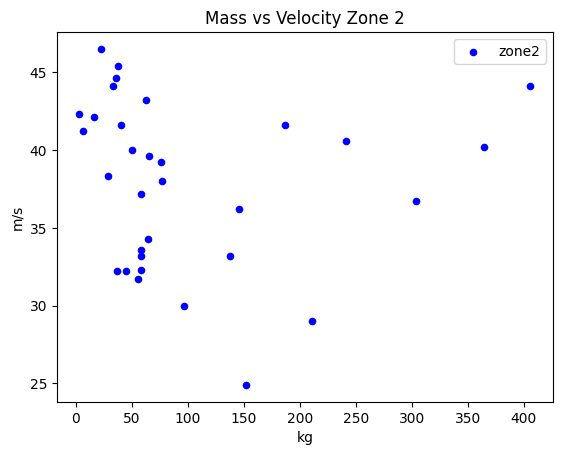

In [13]:
zone2.plot(
    x="kg",
    y="m/s",
    kind="scatter",
    c="blue",
    label="zone2",
    title="Mass vs Velocity Zone 2",
)
plt.show()

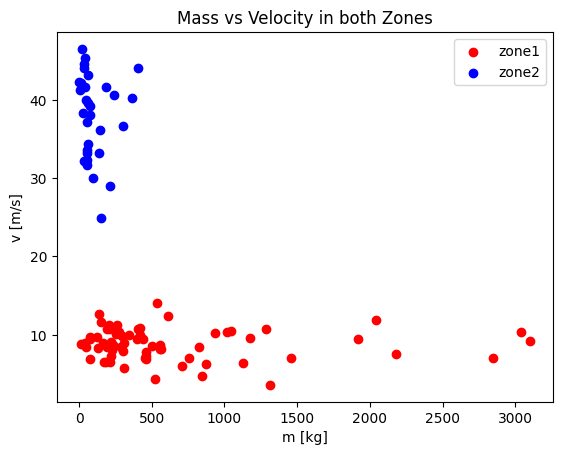

In [14]:
fig, ax = plt.subplots()
ax.scatter(zone1["kg"], zone1["m/s"], c="red", label="zone1")
ax.scatter(zone2["kg"], zone2["m/s"], c="blue", label="zone2")
ax.legend()
ax.axes.set_xlabel("m [kg]")
ax.axes.set_ylabel("v [m/s]")
plt.title("Mass vs Velocity in both Zones")
plt.show()

Zonen 1 und 2 sollten nicht gemischt werden, weil sonst sehr schwere steine generiert werden könnten die eine hohe Geschwindigkeit haben, was in den Aufzeichnungen aber nicht vorkomt (nicht gleiche Grundgesammtheit).

In [15]:
zone1["kj"] = 0.5 * zone1["kg"] * (zone1["m/s"] ** 2) / 1000
zone2["kj"] = 0.5 * zone2["kg"] * (zone2["m/s"] ** 2) / 1000

In [16]:
# Convert the 'date' and 'time' columns to datetime for zone1
zone1["datetime"] = pd.to_datetime(zone1["date"] + " " + zone1["time"])

# Calculate the time difference between each row and the row above, in hours then set the first row to the median of all rows
zone1["timediv h"] = (zone1["datetime"] - zone1["datetime"].shift()).fillna(
    pd.Timedelta(seconds=0)
)
zone1["timediv h"] = zone1["timediv h"].apply(
    lambda x: int(round(x.total_seconds() / 3600))
)

# Set the first row to the median of all rows so we don't loose a value
zone1.loc[0, "timediv h"] = zone1["timediv h"].median()

# Print the updated dataframe
print(zone1)

          date   time      kg  m/s          kj            datetime  timediv h
0   2019-01-01  09:00   194.0  8.4    6.844320 2019-01-01 09:00:00         22
1   2019-01-01  21:00   224.0  8.8    8.673280 2019-01-01 21:00:00         12
2   2019-01-02  14:00  3104.0  9.2  131.361280 2019-01-02 14:00:00         17
3   2019-01-04  15:00   228.0  8.0    7.296000 2019-01-04 15:00:00         49
4   2019-01-05  23:00   755.0  7.0   18.497500 2019-01-05 23:00:00         32
..         ...    ...     ...  ...         ...                 ...        ...
63  2019-03-18  16:00   167.0  8.9    6.614035 2019-03-18 16:00:00         28
64  2019-03-22  18:00  2847.0  7.0   69.751500 2019-03-22 18:00:00         98
65  2019-03-26  00:00    44.0  8.9    1.742620 2019-03-26 00:00:00         78
66  2019-03-26  06:00    45.0  8.4    1.587600 2019-03-26 06:00:00          6
67  2019-03-27  16:00   312.0  5.8    5.247840 2019-03-27 16:00:00         34

[68 rows x 7 columns]


In [17]:
# Convert the 'date' and 'time' columns to datetime for zone2
zone2["datetime"] = pd.to_datetime(zone2["date"] + " " + zone2["time"])

# Calculate the time difference between each row and the row above, in hours
zone2["timediv h"] = (zone2["datetime"] - zone2["datetime"].shift()).fillna(
    pd.Timedelta(seconds=0)
)
zone2["timediv h"] = zone2["timediv h"].apply(
    lambda x: int(round(x.total_seconds() / 3600))
)

# Set the first row to the median of all rows so we don't loose a value
zone2.loc[0, "timediv h"] = zone2["timediv h"].median()

# Print the updated dataframe
print(zone2)

          date   time     kg   m/s          kj            datetime  timediv h
0   2019-01-01  09:00   38.0  45.4   39.162040 2019-01-01 09:00:00       48.5
1   2019-01-03  06:00  187.0  41.6  161.807360 2019-01-03 06:00:00       45.0
2   2019-01-04  10:00   36.0  44.6   35.804880 2019-01-04 10:00:00       28.0
3   2019-01-07  14:00    6.0  41.2    5.092320 2019-01-07 14:00:00       76.0
4   2019-01-11  06:00   65.0  39.6   50.965200 2019-01-11 06:00:00       88.0
5   2019-01-11  16:00   58.0  33.2   31.964960 2019-01-11 16:00:00       10.0
6   2019-01-14  11:00  365.0  40.2  294.927300 2019-01-14 11:00:00       67.0
7   2019-01-16  02:00   22.0  46.5   23.784750 2019-01-16 02:00:00       39.0
8   2019-01-18  06:00  146.0  36.2   95.662120 2019-01-18 06:00:00       52.0
9   2019-01-19  17:00   29.0  38.3   21.269905 2019-01-19 17:00:00       35.0
10  2019-01-20  22:00   40.0  41.6   34.611200 2019-01-20 22:00:00       29.0
11  2019-01-21  11:00  304.0  36.7  204.727280 2019-01-21 11:00:

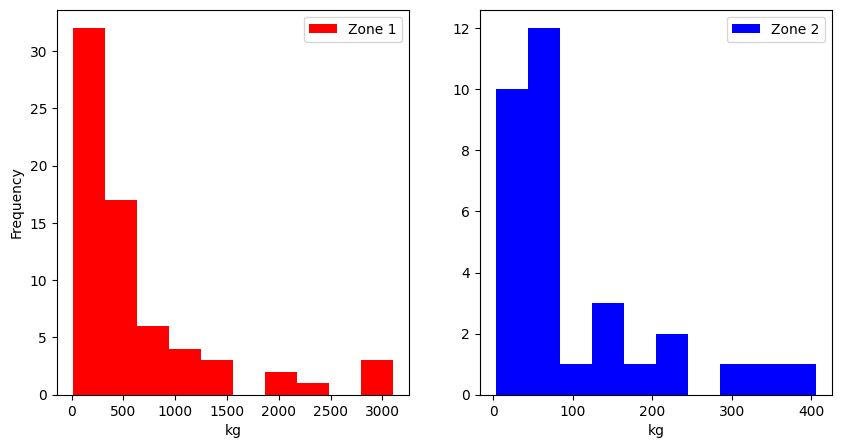

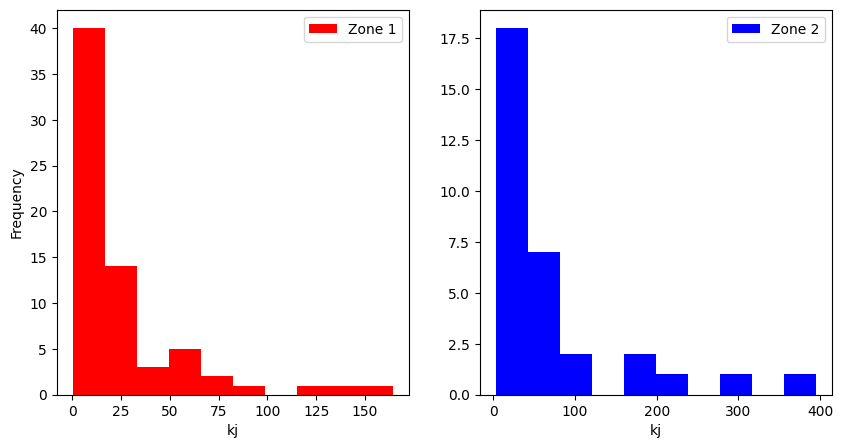

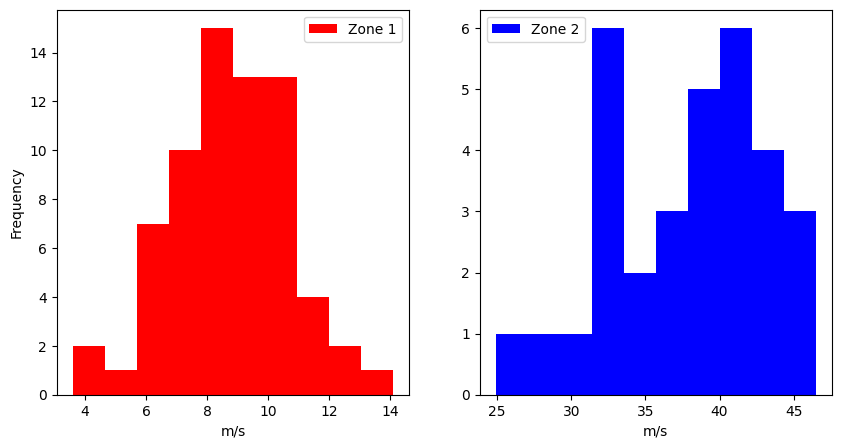

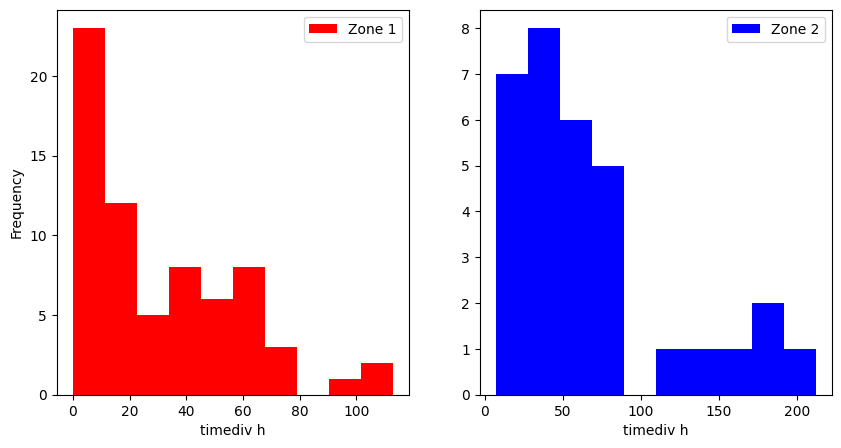

In [18]:
num_bins = 10

# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kg"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kg"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kj"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kj"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kj")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kj")
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["m/s"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["m/s"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("m/s")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("m/s")
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["timediv h"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["timediv h"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("timediv h")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("timediv h")
ax2.legend()
plt.show()

In [19]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                                          zone2             \
                kg        m/s          kj   timediv h          kg        m/s   
count    68.000000  68.000000   68.000000   68.000000   32.000000  32.000000   
mean    628.632353   8.788235   25.197761   30.426471  101.062500  37.790625   
std     695.884703   1.989189   32.704933   27.560688  102.785382   5.395778   
min      12.000000   3.600000    0.464640    0.000000    3.000000  24.900000   
25%     214.750000   7.300000    8.214900    6.000000   37.750000  33.200000   
50%     402.500000   8.800000   12.815133   22.000000   58.000000  38.750000   
75%     773.000000  10.125000   23.135955   49.000000  140.000000  41.725000   
max    3104.000000  14.100000  164.403200  113.000000  406.000000  46.500000   

                               
               kj   timediv h  
count   32.000000   32.000000  
mean    72.543707   65.765625  
std     87.452601   54.372815  
min      2.683935    7.000000  
25%     29.600176   28.750000  
50%     39.581020   50.250000  
75%     63.103560   77.250000  
max    394.796430  212.000000

In [20]:
# TODO: understan log-likelihood/MLE
# TODO: what other strategies are there to evaluate how good distributions fit the data?
# TODO: compare distributions VS fitting parameters of one distribution to the data: two different problems/solutions
def cdf_fit(data):
    distributions = [ss.norm, ss.lognorm, ss.expon, ss.gamma]

    # Plot the CDF of the data and the fitted distributions
    plt.hist(
        data,
        bins=len(data),
        density=True,
        cumulative=True,
        alpha=0.5,
        label="Data",
    )
    x = np.linspace(data.min(), data.max() * 1.2, 100)

    for dist in distributions:
        params = dist.fit(data)
        ll = -dist.logpdf(data, *params).sum().round(0)
        plt.plot(x, dist(*params).cdf(x), label=f"{dist.name}, score: {ll}")
        plt.xlabel(data.name)
        plt.ylabel("Cumulative probability")
        plt.legend()

    plt.show()

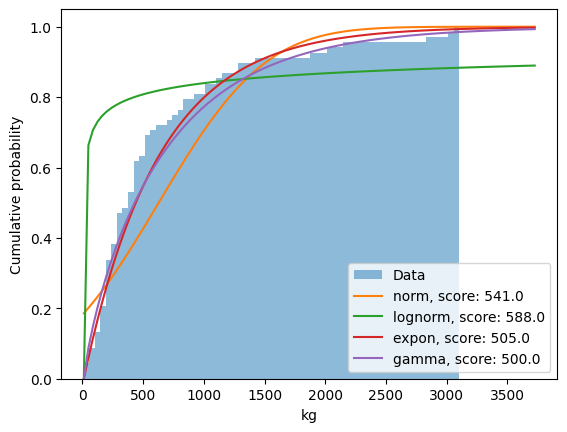

In [21]:
cdf_fit(zone1["kg"])

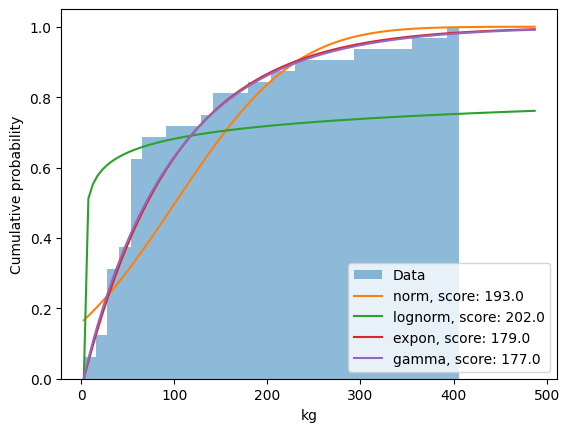

In [22]:
cdf_fit(zone2["kg"])

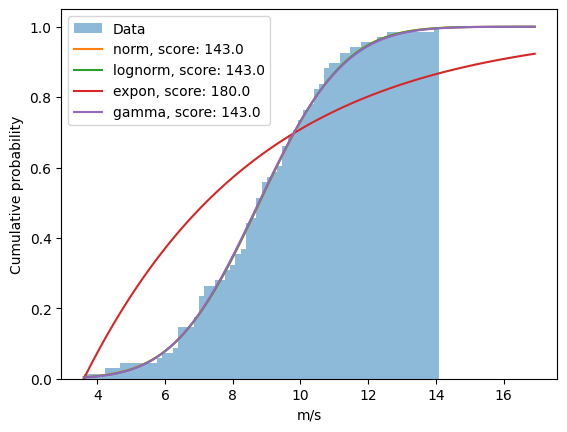

In [23]:
cdf_fit(zone1["m/s"])

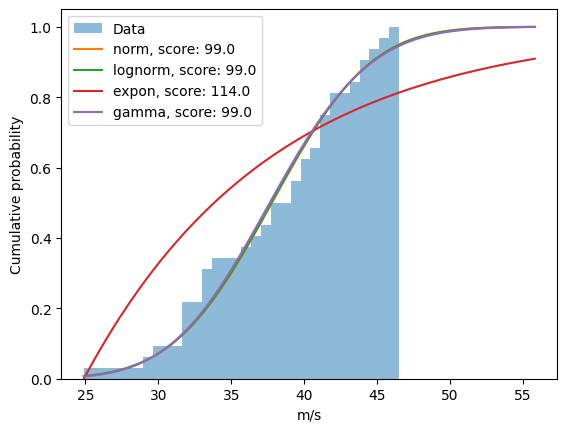

In [24]:
cdf_fit(zone2["m/s"])

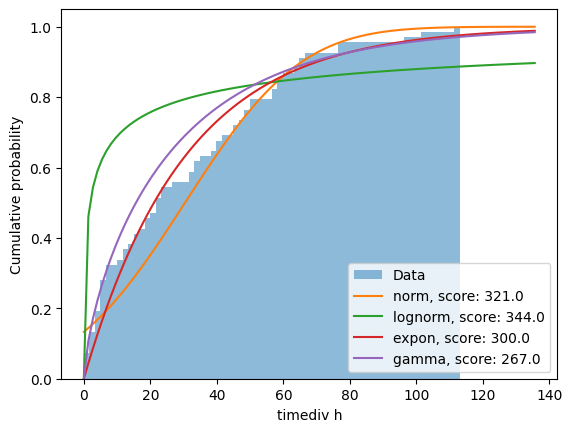

In [25]:
cdf_fit(zone1["timediv h"])

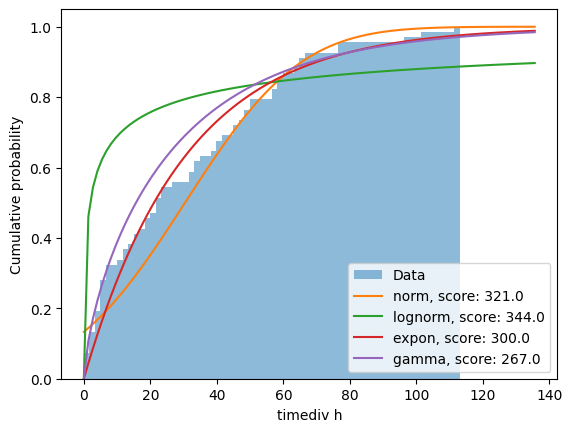

In [26]:
cdf_fit(zone1["timediv h"])

In [27]:
# to simulate a dataframe for the next number of years it will estimate the number of events it takes and generate a frame
def simulate_zone(zone_df, num_years=200):
    timediv_mean = zone_df["timediv h"].mean()

    # Calculate  the deviation
    timediv_params = expon.fit(zone_df["timediv h"])
    kg_params = gamma.fit(zone_df["kg"])
    v_params = norm.fit(zone_df["m/s"])
    # Calculate number of observations for given number of years
    total_hours = num_years * 365.25 * 24
    num_observations = int(total_hours / timediv_mean)

    # Set the starting datetime to January 1st, 2000, 00:00:00
    current_datetime = datetime(2000, 1, 1, 0, 0, 0)

    # Initialize the new dataframe and generate the data
    simulated_df = pd.DataFrame(index=range(num_observations))
    simulated_df["timediv h"] = (
        expon(*timediv_params).rvs(size=num_observations).round(0)
    )
    simulated_df["datetime"] = (
        simulated_df["timediv h"]
        .cumsum()
        .apply(lambda x: current_datetime + timedelta(hours=x))
    )
    simulated_df["kg"] = gamma(*kg_params).rvs(size=num_observations).round(0)
    simulated_df["m/s"] = norm(*v_params).rvs(size=num_observations).round(1)
    simulated_df["kj"] = 0.5 * simulated_df["kg"] * (simulated_df["m/s"] ** 2) / 1000

    return simulated_df

In [28]:
# simulated zones
simulated1 = simulate_zone(zone1)
simulated1["zone"] = 1
simulated2 = simulate_zone(zone2)
simulated2["zone"] = 2
simulated1.describe()
# m/s is the min 0 which is not possible

,timediv h,kg,m/s,kj,zone
count,57620.000000,57620.000000,57620.000000,57620.000000,57620.0
mean,30.340941,676.944863,8.788426,27.482988,1.0
std,30.196997,739.392862,1.976437,34.947077,0.0
min,0.000000,12.000000,0.700000,0.028160,1.0
25%,9.000000,162.000000,7.500000,5.522300,1.0
50%,21.000000,432.000000,8.800000,15.514267,1.0
75%,42.000000,938.000000,10.100000,36.169156,1.0
max,319.000000,9875.000000,17.000000,653.716880,1.0


In [29]:
pd.concat([zone1, simulated1], axis=1, keys=["zone1", "simulated1"]).describe()

zone1                                       simulated1  \
                kg        m/s          kj   timediv h     timediv h   
count    68.000000  68.000000   68.000000   68.000000  57620.000000   
mean    628.632353   8.788235   25.197761   30.426471     30.340941   
std     695.884703   1.989189   32.704933   27.560688     30.196997   
min      12.000000   3.600000    0.464640    0.000000      0.000000   
25%     214.750000   7.300000    8.214900    6.000000      9.000000   
50%     402.500000   8.800000   12.815133   22.000000     21.000000   
75%     773.000000  10.125000   23.135955   49.000000     42.000000   
max    3104.000000  14.100000  164.403200  113.000000    319.000000   

                                                          
                 kg           m/s            kj     zone  
count  57620.000000  57620.000000  57620.000000  57620.0  
mean     676.944863      8.788426     27.482988      1.0  
std      739.392862      1.976437     34.947077      0.0  
min       12.000000      0.700000      0.028160      1.0  
25%      162.000000      7.500000      5.522300      1.0  
50%      432.000000      8.800000     15.514267      1.0  
75%      938.000000     10.100000     36.169156      1.0  
max     9875.000000     17.000000    653.716880      1.0

In [30]:
simulated2.head()

,timediv h,datetime,kg,m/s,kj,zone
0,159.0,2000-01-07 15:00:00,391.0,40.7,323.843795,2
1,32.0,2000-01-08 23:00:00,37.0,43.8,35.491140,2
2,192.0,2000-01-16 23:00:00,98.0,32.2,50.805160,2
3,117.0,2000-01-21 20:00:00,63.0,43.7,60.155235,2
4,81.0,2000-01-25 05:00:00,30.0,34.7,18.061350,2


In [31]:
simulated2.tail()

,timediv h,datetime,kg,m/s,kj,zone
26653,44.0,2200-08-24 12:00:00,10.0,36.2,6.552200,2
26654,22.0,2200-08-25 10:00:00,82.0,46.2,87.512040,2
26655,7.0,2200-08-25 17:00:00,45.0,41.2,38.192400,2
26656,21.0,2200-08-26 14:00:00,128.0,23.3,34.744960,2
26657,149.0,2200-09-01 19:00:00,93.0,30.7,43.825785,2


c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


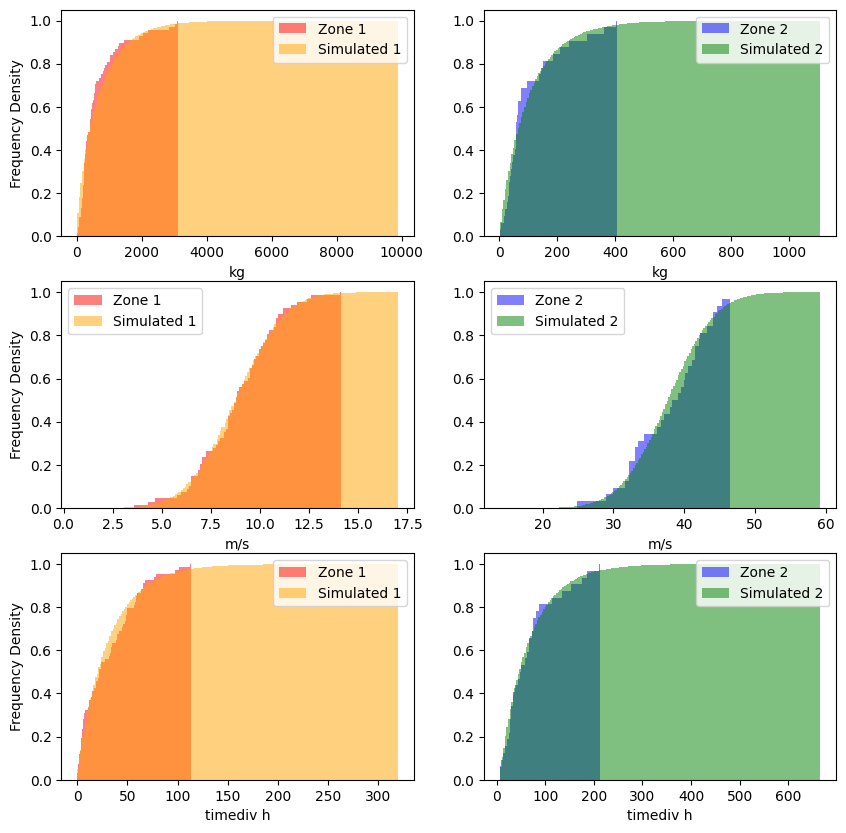

In [32]:
# Set variables
num_bins = 200
cumulative = True

# Plot the histograms for 'kg', 'm/s', and 'timediv h'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10))

# Histogram for 'kg'
ax1.hist(
    zone1["kg"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax1.hist(
    simulated1["kg"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    zone2["kg"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    simulated2["kg"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency Density")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()

# Histogram for 'm/s'
ax3.hist(
    zone1["m/s"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax3.hist(
    simulated1["m/s"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    zone2["m/s"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    simulated2["m/s"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax3.set_xlabel("m/s")
ax3.set_ylabel("Frequency Density")
ax3.legend()
ax4.set_xlabel("m/s")
ax4.legend()

# Histogram for 'timediv h'
ax5.hist(
    zone1["timediv h"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax5.hist(
    simulated1["timediv h"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    zone2["timediv h"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    simulated2["timediv h"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax5.set_xlabel("timediv h")
ax5.set_ylabel("Frequency Density")
ax5.legend()
ax6.set_xlabel("timediv h")
ax6.legend()

plt.show()

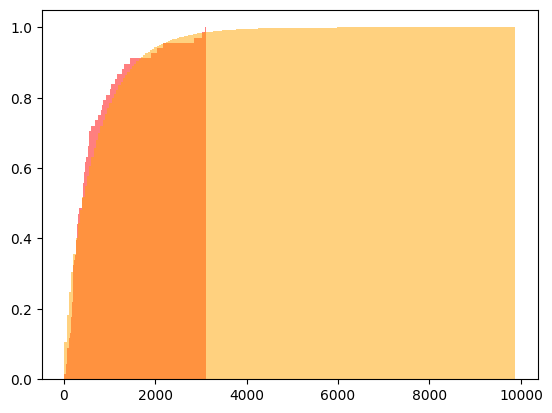

In [33]:
def compare_simulated_to_original(
    original_column, simulated_column, num_bins=200, cumulative=True
):
    plt.hist(
        original_column,
        bins=num_bins,
        color="red",
        alpha=0.5,
        label="Zone 1",
        density=True,
        cumulative=cumulative,
    )
    plt.hist(
        simulated_column,
        bins=num_bins,
        color="orange",
        alpha=0.5,
        label="Simulated 1",
        density=True,
        cumulative=cumulative,
    )

    ax1.set_xlabel(original_column.name)
    ax1.set_ylabel("Frequency Density")
    ax1.legend()


compare_simulated_to_original(zone1["kg"], simulated1["kg"])

In [34]:
# Determine the latest end datetime of the two dataframes
max_datetime = min(simulated1["datetime"].max(), simulated2["datetime"].max())

# Set the end datetime of both dataframes to be the same
simulated1 = simulated1[simulated1["datetime"] <= max_datetime]
simulated2 = simulated2[simulated2["datetime"] <= max_datetime]

# Merge the two dataframes together, sort by datetime, and reset the index
simulated_df = pd.concat([simulated1, simulated2])
simulated_df = simulated_df.sort_values("datetime")
simulated_df = simulated_df.reset_index(drop=True)

In [35]:
simulated_df.describe()

,timediv h,kg,m/s,kj,zone
count,84107.000000,84107.000000,84107.000000,84107.000000,84107.000000
mean,41.568122,495.791884,17.917852,42.183601,1.314920
std,44.566328,670.278457,13.891662,58.188554,0.464487
min,0.000000,3.000000,0.700000,0.028160,1.000000
25%,12.000000,73.000000,8.100000,7.760965,1.000000
50%,27.000000,224.000000,10.000000,22.021000,1.000000
75%,55.000000,660.000000,33.400000,52.846133,2.000000
max,666.000000,9875.000000,59.200000,972.984960,2.000000


In [36]:
# here i look at the tail to make shure the dates got calculated correctly.
simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone
84087,38.0,2199-05-21 01:00:00,584.0,9.3,25.255080,1
84088,66.0,2199-05-23 00:00:00,262.0,42.2,233.290040,2
84089,80.0,2199-05-24 09:00:00,17.0,6.7,0.381565,1
84090,8.0,2199-05-24 17:00:00,303.0,11.2,19.004160,1
84091,42.0,2199-05-24 18:00:00,148.0,40.8,123.183360,2
84092,20.0,2199-05-25 13:00:00,2842.0,10.5,156.665250,1
84093,7.0,2199-05-25 20:00:00,1508.0,7.6,43.551040,1
84094,51.0,2199-05-26 21:00:00,277.0,41.3,236.238065,2
84095,31.0,2199-05-27 03:00:00,988.0,5.1,12.848940,1
84096,8.0,2199-05-27 05:00:00,80.0,37.4,55.950400,2


because the reaction time is 24h we will asume that the nets will get emptied every evening if there are stones in it.


In [37]:
# add a column that calculates the cumulative kg already in the net.

# first group the data by date
grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

# then calculate the cumulative sum of 'kg' within each group
simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
# and subtract the 'kg' valueof the new stone to get the weight in the net
simulated_df["cumulative_kg"] = simulated_df["cumulative_kg"] - simulated_df["kg"]

In [38]:
# should we disregard the rest stones of the day if the net broke trough?
# after this the road probably gets closed

# Add a new column 'breakthrough'
simulated_df["breakthrough"] = 0

# Set breakthrough to 1 where conditions are met
condition1 = simulated_df["kj"] > 1000
condition2 = (simulated_df["cumulative_kg"] > 2000) & (simulated_df["kj"] > 500)
simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

In [39]:
# here i look at the tail to make shure the cumulative_kg and breakthrough got calculated correctly.

simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone,cumulative_kg,breakthrough
84087,38.0,2199-05-21 01:00:00,584.0,9.3,25.255080,1,0.0,0
84088,66.0,2199-05-23 00:00:00,262.0,42.2,233.290040,2,0.0,0
84089,80.0,2199-05-24 09:00:00,17.0,6.7,0.381565,1,0.0,0
84090,8.0,2199-05-24 17:00:00,303.0,11.2,19.004160,1,17.0,0
84091,42.0,2199-05-24 18:00:00,148.0,40.8,123.183360,2,320.0,0
84092,20.0,2199-05-25 13:00:00,2842.0,10.5,156.665250,1,0.0,0
84093,7.0,2199-05-25 20:00:00,1508.0,7.6,43.551040,1,2842.0,0
84094,51.0,2199-05-26 21:00:00,277.0,41.3,236.238065,2,0.0,0
84095,31.0,2199-05-27 03:00:00,988.0,5.1,12.848940,1,0.0,0
84096,8.0,2199-05-27 05:00:00,80.0,37.4,55.950400,2,988.0,0


In [40]:
# Calculate the probability of a breakthrough
first_day = simulated_df["datetime"].min().date()
last_day = simulated_df["datetime"].max().date()
num_days = (last_day - first_day).days + 1

breaktroughs_prbability = (simulated_df["breakthrough"] == 1).sum() / num_days
breaktroughs_prbability

6.864171769034348e-05

In [41]:
simulated_df["breakthrough"].value_counts()

0    84102
1        5
Name: breakthrough, dtype: int64

In [43]:
# a 5m car driving 60 will be in this zone for:
def calculate_danger_time():
    velocity = 60 / 3.6
    print("velocity:", velocity, "m/s")
    danger_time = 5 / velocity
    print("danger time: ", danger_time, "s")
    # with 1200 cars a day this will be that amount of seconds in danger:
    total_danger_time = 1200 * danger_time
    print("total danger time:", total_danger_time, "s")
    # precentage of cars being in danger per day:
    danger_time_proportion = total_danger_time / (24 * 60 * 60)
    print("danger time proportion: ", danger_time_proportion * 100, "%")
    return danger_time_proportion


danger_time_proportion = calculate_danger_time()

# how likely is it that a car will be in danger and the net will break trough?
dead_probability = breaktroughs_prbability * danger_time_proportion
print("dead probability:", dead_probability * 100, "%")

velocity: 16.666666666666668 m/s
danger time:  0.3 s
total danger time: 360.0 s
danger time proportion:  0.4166666666666667 %
dead probability: 2.8600715704309786e-05 %


In [44]:
(simulated_df["breakthrough"] == 1).sum()

5

In [45]:
def simulate_combined():
    # simulated zones
    sim1 = simulate_zone(zone1)
    sim1["zone"] = 1
    sim2 = simulate_zone(zone2)
    sim2["zone"] = 2
    sim1.describe()

    # Determine the latest end datetime of the two dataframes
    max_datetime = min(sim1["datetime"].max(), sim2["datetime"].max())

    # Set the end datetime of both dataframes to be the same
    sim1 = sim1[sim1["datetime"] <= max_datetime]
    sim2 = sim2[sim2["datetime"] <= max_datetime]

    # Merge the two dataframes together, sort by datetime, and reset the index
    simulated_df = pd.concat([sim1, sim2])
    simulated_df = simulated_df.sort_values("datetime")
    simulated_df = simulated_df.reset_index(drop=True)

    # add a column that calculates the cumulative kg already in the net.
    # first group the data by date
    grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

    # then calculate the cumulative sum of 'kg' within each group
    simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
    # and subtract the 'kg' valueof the new stone to get the weight in the net
    simulated_df["cumulative_kg"] = simulated_df["cumulative_kg"] - simulated_df["kg"]

    # Add a new column 'breakthrough' and set it to 1 where conditions are met
    simulated_df["breakthrough"] = 0
    condition1 = simulated_df["kj"] > 1000
    condition2 = (simulated_df["cumulative_kg"] > 2000) & (simulated_df["kj"] > 500)
    simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

    # Calculate days passed
    first_day = simulated_df["datetime"].min().date()
    last_day = simulated_df["datetime"].max().date()
    num_days = (last_day - first_day).days + 1

    breakthroughs = simulated_df["breakthrough"].sum()

    return breakthroughs, num_days

In [46]:
def simulate_years(years=10000):
    breakthroughs = 0
    num_days = 0
    while num_days < (years * 365):
        a, b = simulate_combined()
        breakthroughs += a
        num_days += b
    probability = breakthroughs / num_days
    return breakthroughs, num_days, probability


simulate_years()

(175, 3711950, 4.714503158717116e-05)